## Import Packages and Install Packages

In [29]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import pandas as pd

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models import CoxPH
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [31]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Data

In [38]:
file_path = "./drive/MyDrive/Colab Notebooks/Data/"

X = pd.read_csv(file_path + "source/source_X2.csv")
y = pd.read_csv(file_path + "source/source_Y2.csv")
y.columns = ["duration", "event"]

df_train = pd.concat([X, y], axis=1)
#df_train = metabric.read_df()

X_test = pd.read_csv(file_path + "train_test/train_X.csv")
y_test = pd.read_csv(file_path + "train_test/train_y.csv")
y_test.columns = ["duration", "event"]
df_test = pd.concat([X, y], axis=1)

df_val = df_test #df_train.sample(frac=0.2)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,duration,event
0,0.326816,-0.478564,-1.007512,1.806841,0.147439,0.419568,1.012171,-0.551501,-0.982596,-2.351120,...,-2.110162,-0.557473,-0.892230,1.086832,0.765607,0.114790,-2.810196,0.446754,8.888686,1.0
1,-1.180701,-1.253449,0.099676,-1.222052,0.048732,0.667359,0.826158,0.367048,-0.257458,2.271633,...,-1.492733,-0.440637,-0.779296,1.280566,-0.565882,-0.491117,-0.296226,-0.128087,0.555577,1.0
2,-0.097421,-1.547242,0.681423,-0.419628,0.331624,0.666736,1.156998,-1.093963,0.194354,-0.062224,...,1.168050,1.134343,0.807728,1.059853,2.371113,-0.691801,1.256379,0.330202,1.384547,1.0
3,1.200569,1.318675,-0.518763,0.656789,-0.144075,0.920097,-1.390267,1.321413,1.976545,0.837004,...,-0.598856,0.120449,-0.601664,-0.366647,0.226456,-0.384254,-0.691105,1.299226,0.858823,0.0
4,-0.298056,1.060344,1.089916,-0.273355,0.253722,-0.134529,-0.685547,-1.296064,0.889270,-0.385121,...,0.838309,-0.390310,0.729220,-1.445322,-0.400220,0.025627,-0.169584,0.992833,8.498274,1.0


In [15]:
cols_standardize = [str(i) for i in range(X.shape[1])]
cols_leave = []
#cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
#cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [76]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

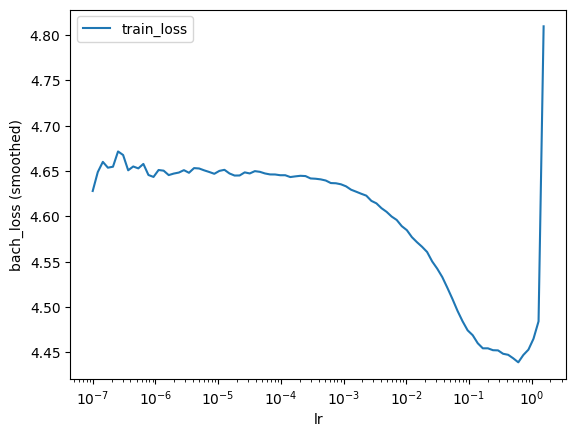

In [78]:
#model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [79]:
lrfinder.get_best_lr()

0.0613590727341321

We include the EarlyStopping callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.


105:	[0s / 0s],		train_loss: 2.9963,	val_loss: 5.3675
106:	[0s / 0s],		train_loss: 2.9874,	val_loss: 5.3780
107:	[0s / 1s],		train_loss: 2.9838,	val_loss: 5.3740
108:	[0s / 1s],		train_loss: 2.9621,	val_loss: 5.3631
109:	[0s / 1s],		train_loss: 2.9555,	val_loss: 5.3601
110:	[0s / 1s],		train_loss: 2.9837,	val_loss: 5.3529
111:	[0s / 2s],		train_loss: 2.9338,	val_loss: 5.3496
112:	[0s / 2s],		train_loss: 2.9800,	val_loss: 5.3496
113:	[0s / 2s],		train_loss: 2.9299,	val_loss: 5.3572
114:	[0s / 3s],		train_loss: 2.9861,	val_loss: 5.3721
115:	[0s / 3s],		train_loss: 3.0225,	val_loss: 5.3814
116:	[0s / 4s],		train_loss: 2.9677,	val_loss: 5.3895
117:	[0s / 4s],		train_loss: 2.9899,	val_loss: 5.3918
118:	[0s / 4s],		train_loss: 2.9614,	val_loss: 5.3742
119:	[0s / 4s],		train_loss: 2.9507,	val_loss: 5.3368
120:	[0s / 4s],		train_loss: 2.9268,	val_loss: 5.3143
121:	[0s / 4s],		train_loss: 2.9296,	val_loss: 5.3041
122:	[0s / 4s],		train_loss: 2.9525,	val_loss: 5.3206
123:	[0s / 4s],		train_loss:

-3.9685583

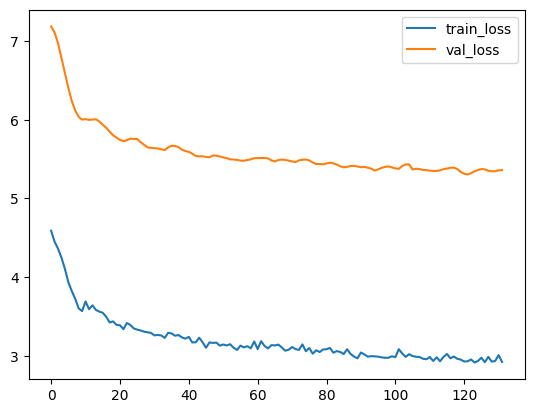

In [82]:
model.optimizer.set_lr(0.01)

epochs = 120 #512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

_ = log.plot()
model.partial_log_likelihood(*val).mean()

## Prediction

For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as Cox-Time is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [85]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

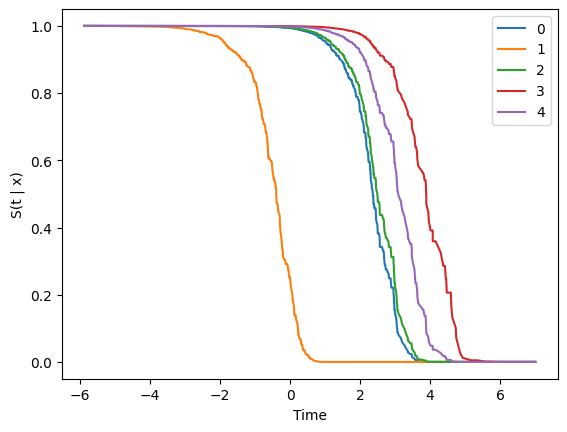

In [110]:
surv.index = np.log(surv.index)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


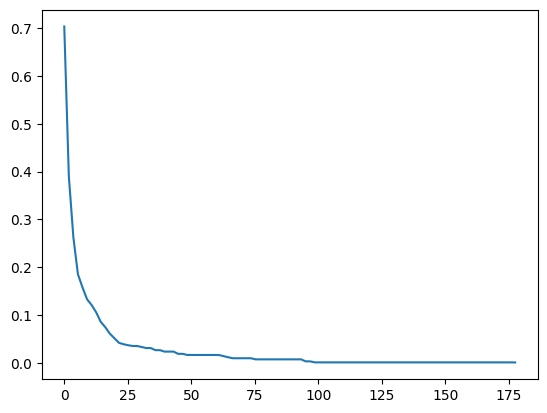

In [87]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [88]:
ev.concordance_td()

0.8409133381200146

## All in One

0:	[0s / 0s],		train_loss: 4.6374,	val_loss: 7.1554
1:	[0s / 0s],		train_loss: 4.4278,	val_loss: 7.0556
2:	[0s / 0s],		train_loss: 4.3263,	val_loss: 6.9225
3:	[0s / 0s],		train_loss: 4.2198,	val_loss: 6.7540
4:	[0s / 1s],		train_loss: 4.0850,	val_loss: 6.5660
5:	[0s / 1s],		train_loss: 3.9229,	val_loss: 6.3857
6:	[0s / 1s],		train_loss: 3.8235,	val_loss: 6.2314
7:	[0s / 1s],		train_loss: 3.7222,	val_loss: 6.1184
8:	[0s / 1s],		train_loss: 3.6607,	val_loss: 6.0280
9:	[0s / 1s],		train_loss: 3.5728,	val_loss: 5.9910
10:	[0s / 1s],		train_loss: 3.6109,	val_loss: 5.9713
11:	[0s / 1s],		train_loss: 3.6599,	val_loss: 5.9647
12:	[0s / 1s],		train_loss: 3.5580,	val_loss: 5.9534
13:	[0s / 1s],		train_loss: 3.5651,	val_loss: 5.9285
14:	[0s / 1s],		train_loss: 3.4960,	val_loss: 5.8893
15:	[0s / 1s],		train_loss: 3.5548,	val_loss: 5.8383
16:	[0s / 1s],		train_loss: 3.4570,	val_loss: 5.8369
17:	[0s / 1s],		train_loss: 3.4468,	val_loss: 5.8248
18:	[0s / 1s],		train_loss: 3.4326,	val_loss: 5.8165
19:

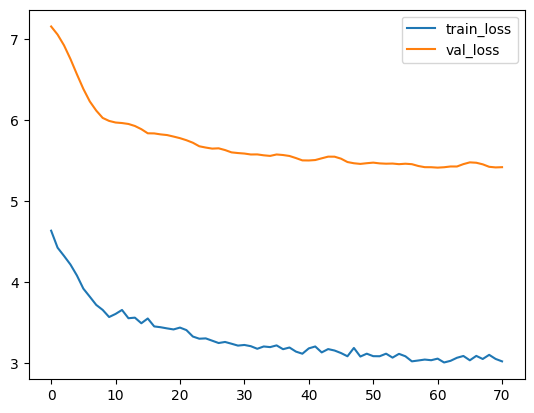

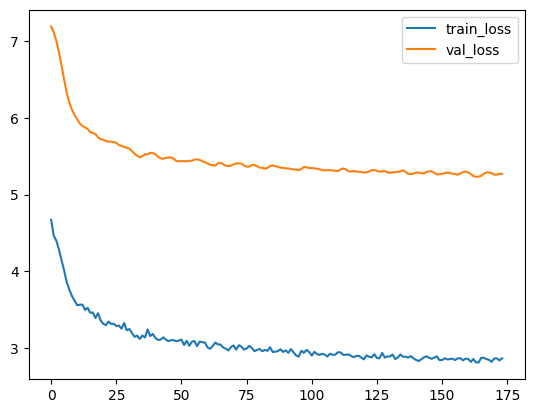

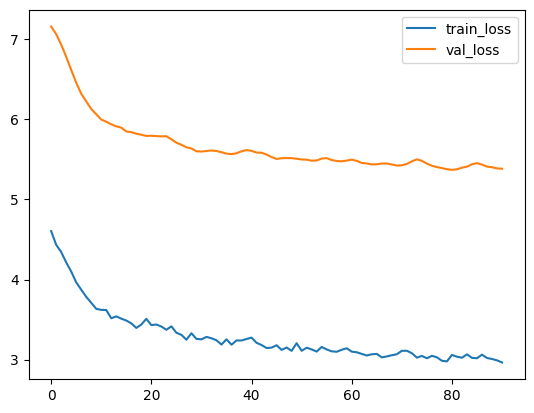

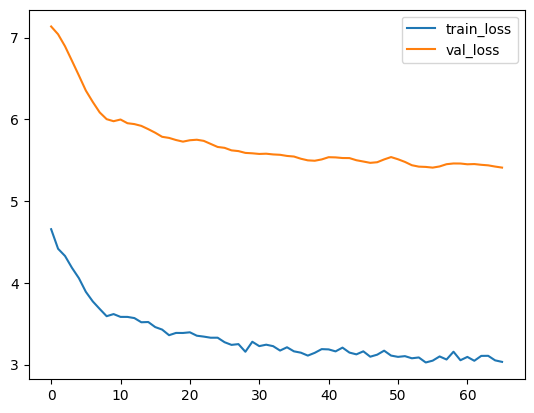

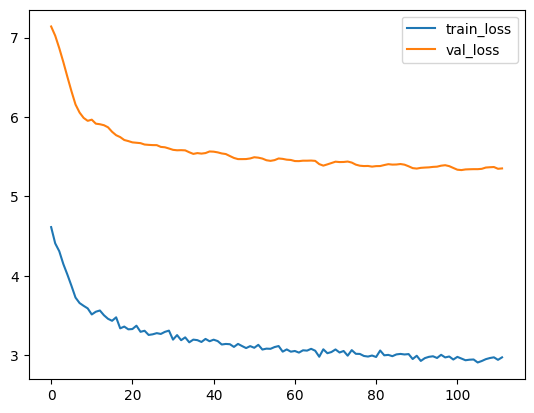

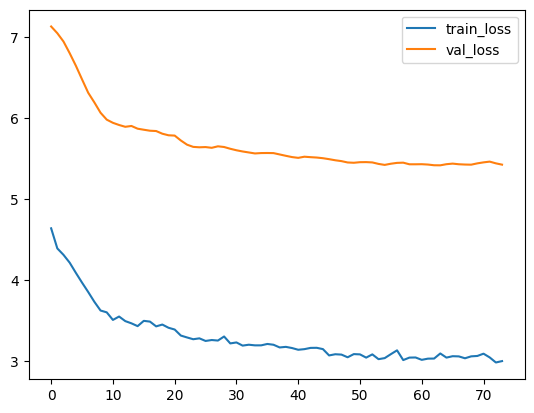

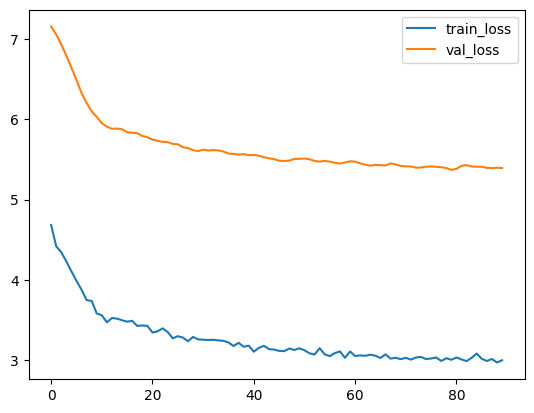

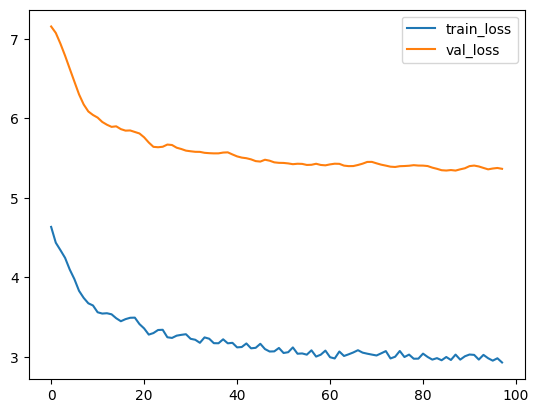

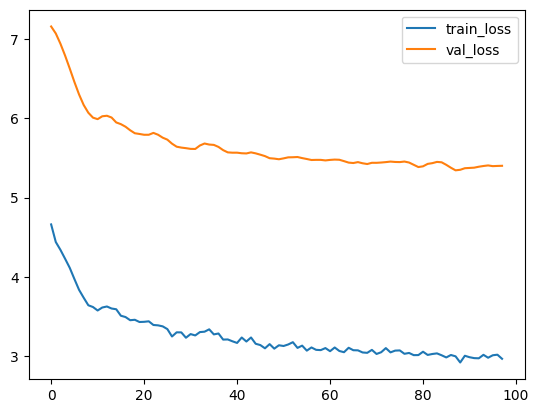

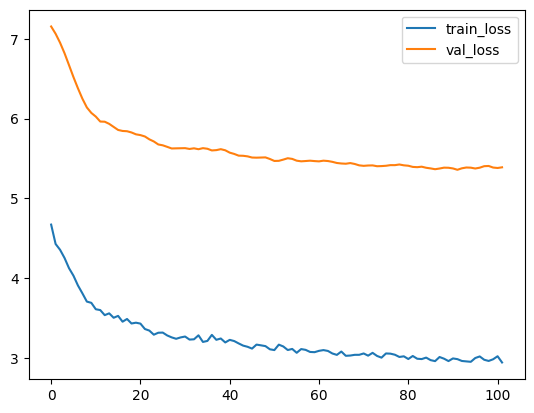

In [95]:
file_path = "./drive/MyDrive/Colab Notebooks/Data/"

to_save = np.zeros((1000, 10))

for i in range(10):
  X = pd.read_csv(file_path + "source/source_X" + str(i+1) + ".csv")
  y = pd.read_csv(file_path + "source/source_Y" + str(i+1) + ".csv")
  y.columns = ["duration", "event"]

  df_train = pd.concat([X, y], axis=1)

  X_test = pd.read_csv(file_path + "train_test/train_X.csv")
  y_test = pd.read_csv(file_path + "train_test/train_y.csv")
  y_test.columns = ["duration", "event"]
  df_test = pd.concat([X, y], axis=1)

  df_val = df_test #df_train.sample(frac=0.2)

  cols_standardize = [str(i) for i in range(X.shape[1])]
  cols_leave = []

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(df_train).astype('float32')
  x_val = x_mapper.transform(df_val).astype('float32')
  x_test = x_mapper.transform(df_test).astype('float32')

  labtrans = CoxTime.label_transform()
  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  y_val = labtrans.transform(*get_target(df_val))
  durations_test, events_test = get_target(df_test)
  val = tt.tuplefy(x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = 1
  batch_norm = True
  dropout = 0.1
  output_bias = False

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                dropout, output_bias=output_bias)

  model = CoxPH(net, tt.optim.Adam)
  batch_size = 256
  model.optimizer.set_lr(0.01)

  epochs = 256
  callbacks = [tt.callbacks.EarlyStopping()]
  verbose = True

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val.repeat(10).cat())

  _ = log.plot()

  to_save[:, i] = model.predict_net(x_test)[:, 0]


0:	[0s / 0s],		train_loss: 4.5771,	val_loss: 4.2509
1:	[0s / 0s],		train_loss: 4.2603,	val_loss: 4.1684
2:	[0s / 0s],		train_loss: 4.1905,	val_loss: 4.0685
3:	[0s / 1s],		train_loss: 4.0879,	val_loss: 3.9356
4:	[0s / 1s],		train_loss: 3.9904,	val_loss: 3.7756
5:	[0s / 1s],		train_loss: 3.8448,	val_loss: 3.6156
6:	[0s / 1s],		train_loss: 3.6505,	val_loss: 3.4508
7:	[0s / 1s],		train_loss: 3.5159,	val_loss: 3.2604
8:	[0s / 1s],		train_loss: 3.4361,	val_loss: 3.1091
9:	[0s / 1s],		train_loss: 3.3409,	val_loss: 3.0093
10:	[0s / 1s],		train_loss: 3.2412,	val_loss: 2.9530
11:	[0s / 1s],		train_loss: 3.2113,	val_loss: 2.9574
12:	[0s / 1s],		train_loss: 3.2942,	val_loss: 2.9274
13:	[0s / 1s],		train_loss: 3.2508,	val_loss: 2.9188
14:	[0s / 1s],		train_loss: 3.2115,	val_loss: 2.8943
15:	[0s / 1s],		train_loss: 3.2089,	val_loss: 2.8526
16:	[0s / 1s],		train_loss: 3.1524,	val_loss: 2.8177
17:	[0s / 1s],		train_loss: 3.1345,	val_loss: 2.7865
18:	[0s / 1s],		train_loss: 3.0931,	val_loss: 2.7641
19:

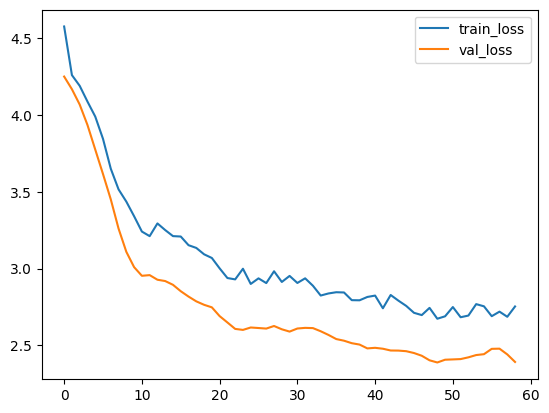

In [105]:
X = pd.read_csv(file_path + "train_test/train_X.csv")
y = pd.read_csv(file_path + "train_test/train_y.csv")
y.columns = ["duration", "event"]

df_train = pd.concat([X, y], axis=1)

X_test = pd.read_csv(file_path + "train_test/train_X.csv")
y_test = pd.read_csv(file_path + "train_test/train_y.csv")
y_test.columns = ["duration", "event"]
df_test = pd.concat([X, y], axis=1)

df_val = df_test

cols_standardize = [str(i) for i in range(X.shape[1])]
cols_leave = []

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                                dropout, output_bias=output_bias)

model = CoxPH(net, tt.optim.Adam)
batch_size = 256
model.optimizer.set_lr(0.01)

epochs = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

_ = log.plot()


In [108]:
#pd.DataFrame(model.predict_net(x_test)).to_csv("./drive/MyDrive/SSS/Gang_regressor_beta.csv", index=False)

In [109]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.9755883137228759

In [102]:
#pd.DataFrame(to_save).to_csv("./drive/MyDrive/SSS/Gang_regressor.csv", index=False)